In [ ]:
import json
import re
import pandas as pd

import nltk
from nltk.corpus import stopwords

nltk.download("punkt_tab")
nltk.download("stopwords")
stopwords_en = set(stopwords.words("english"))

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hades\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hades\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Cargar dataset
ruta_ds = "Movies_and_TV_5.json"

reviews = []
with open(ruta_ds, "r") as f:
    for line in f:
        reviews.append(json.loads(line))
df = pd.DataFrame(reviews)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


In [ ]:
# Crear columna de sentimiento y quitar valor neutro
df_limpio = df[df["overall"] != 3].copy()
df_limpio["sentiment"] = df_limpio["overall"].apply(lambda x: 1 if x > 3 else 0)
df_limpio["sentiment"].value_counts()

sentiment
1    1289602
0     206629
Name: count, dtype: int64

In [ ]:
# Convertir a minúsculas
def minusculas(texto):
    return texto.lower()

In [ ]:
# Limpiar corpus de tecto no deseado
def limpiezaCorpus(texto):
    texto = re.sub(r"http\S+|www\S+|https\S+", '', texto)
    texto = re.sub(r"\d+", "", texto)   
    texto = re.sub(r'\@w+|\#','', texto)
    texto = re.sub(r'[^A-Za-z0-9]+', ' ', texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

In [ ]:
# Tokenizar el texto
def tokensTxt(texto):
    return nltk.word_tokenize(texto)

In [ ]:
# Eliminar stopwords
def quitar_Stopwords(tokens):
    return [t for t in tokens if t not in stopwords_en]

In [ ]:
# Agrupar tokens en un solo texto
def agrupar (texto):
    return " ".join(texto)

In [ ]:
# Procesar Texto con funciones anteriores
def Procesa_txt(texto):
    if not isinstance(texto, str):
        return ""
    texto = texto.strip()
    if not texto:
        return ""
    texto = minusculas(texto)
    
    texto = limpiezaCorpus(texto)
    
    tokens = tokensTxt(texto)
    
    tokens = quitar_Stopwords(tokens)
    
    texto_limpio  = agrupar(tokens)
    
    return "".join(texto_limpio)

In [ ]:
# Aplicar procesamiento de texto de limpieza
df_limpio["clean_text"] = df["reviewText"].apply(Procesa_txt)
df_limpio[["reviewText", "clean_text"]].head()

,reviewText,clean_text
0,This is a charming version of the classic Dick...,charming version classic dicken tale henry win...
3,Henry Winkler is very good in this twist on th...,henry winkler good twist classic story convent...
4,This is one of the best Scrooge movies out. H...,one best scrooge movies henry winkler outdoes ...
5,This has been a favorite movie of mine for a l...,favorite movie mine long time henry winkler gr...
6,This is the American adaptation of the Charles...,american adaptation charles dickens classic in...


In [ ]:
# Mostrar df limpio
df_limpio.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sentiment,clean_text
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008",1,charming version classic dicken tale henry win...
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008",1,henry winkler good twist classic story convent...
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013",1,one best scrooge movies henry winkler outdoes ...
5,A2L0G56BNOTX6S,0005019281,barbara whapeles,"[0, 0]",This has been a favorite movie of mine for a l...,5.0,Dickens updated.,1383696000,"11 6, 2013",1,favorite movie mine long time henry winkler gr...
6,A5NYUBEKXFLX5,0005019281,"B. Babb ""kites0852""","[1, 1]",This is the American adaptation of the Charles...,5.0,A MUST-HAVE FOR ANY VIDEO CHRISTMAS COLLECTION!!,1230595200,"12 30, 2008",1,american adaptation charles dickens classic in...


In [ ]:
# Obtener x,y para generar el modelo y dividir en train y test
X = df_limpio["clean_text"]
y = df_limpio["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Se aplica CountVectorizer para convertir el texto en una matriz 
countVec = CountVectorizer(max_features=20000,ngram_range=(1,2),min_df=5)
# Transformar los datos de entrenamiento y prueba
X_train_count = countVec.fit_transform(X_train)
X_test_count = countVec.transform(X_test)

In [ ]:
# Aplicar TfidfVectorizer para convertir el texto en una matriz
tfidf_vec = TfidfVectorizer(max_features=20000,ngram_range=(1,2),min_df=5)
# Transformar los datos de entrenamiento y prueba
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

In [ ]:
# Aplicar  Regesion con CountVectorizer
lr_count = LogisticRegression(max_iter=300)
lr_count.fit(X_train_count, y_train)

pred_lr_count = lr_count.predict(X_test_count)

print(classification_report(y_test, pred_lr_count))

              precision    recall  f1-score   support

           0       0.84      0.69      0.76     41326
           1       0.95      0.98      0.97    257921

    accuracy                           0.94    299247
   macro avg       0.90      0.83      0.86    299247
weighted avg       0.94      0.94      0.94    299247



In [ ]:
# Aplicar Regesion con TfidfVectorizer
lr_tfidf = LogisticRegression(max_iter=300)
lr_tfidf.fit(X_train_tfidf, y_train)

pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

print(classification_report(y_test, pred_lr_tfidf))

              precision    recall  f1-score   support

           0       0.86      0.70      0.77     41326
           1       0.95      0.98      0.97    257921

    accuracy                           0.94    299247
   macro avg       0.91      0.84      0.87    299247
weighted avg       0.94      0.94      0.94    299247



In [ ]:
# Aplicar SVM con CountVectorizer
svm_count = LinearSVC()
svm_count.fit(X_train_count, y_train)

pred_svm_count = svm_count.predict(X_test_count)

In [ ]:
# Aplicar SVM con TfidfVectorizer
svm_tfidf = LinearSVC()
svm_tfidf.fit(X_train_tfidf, y_train)

pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)


In [ ]:
# Evaluacion de mnodelos
def evaluar(y_true, y_pred, titulo):
    print(f"\n-{titulo}-\n")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Matriz de Confusión - {titulo}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()



-Regression + CountVectorizer-

              precision    recall  f1-score   support

           0       0.84      0.69      0.76     41326
           1       0.95      0.98      0.97    257921

    accuracy                           0.94    299247
   macro avg       0.90      0.83      0.86    299247
weighted avg       0.94      0.94      0.94    299247



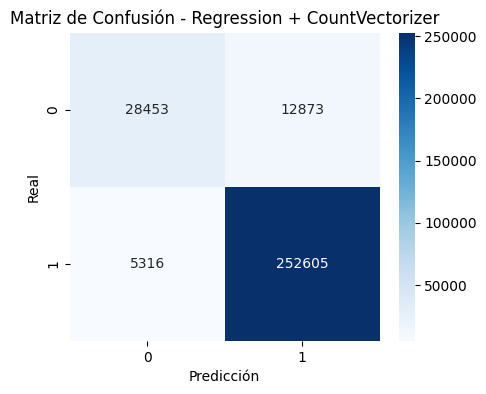


-Regression + TF-IDF-

              precision    recall  f1-score   support

           0       0.86      0.70      0.77     41326
           1       0.95      0.98      0.97    257921

    accuracy                           0.94    299247
   macro avg       0.91      0.84      0.87    299247
weighted avg       0.94      0.94      0.94    299247



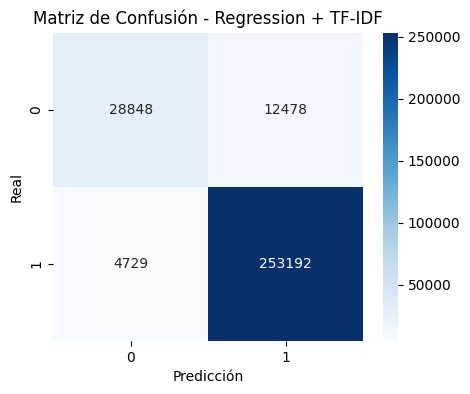


-SVM y CountVectorizer-

              precision    recall  f1-score   support

           0       0.85      0.67      0.75     41326
           1       0.95      0.98      0.96    257921

    accuracy                           0.94    299247
   macro avg       0.90      0.82      0.86    299247
weighted avg       0.94      0.94      0.93    299247



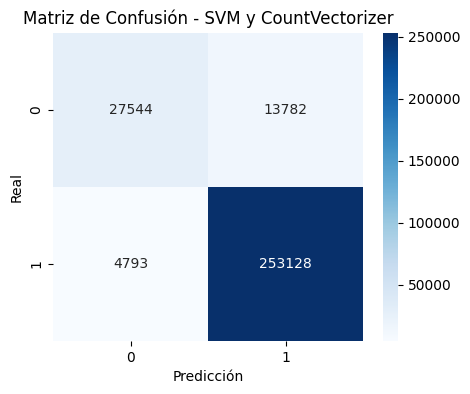


-SVM y TF-IDF-

              precision    recall  f1-score   support

           0       0.85      0.72      0.78     41326
           1       0.96      0.98      0.97    257921

    accuracy                           0.94    299247
   macro avg       0.90      0.85      0.87    299247
weighted avg       0.94      0.94      0.94    299247



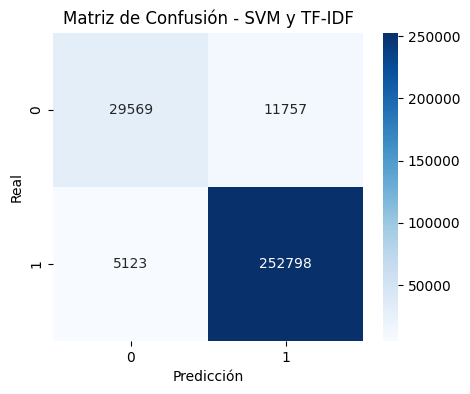

In [ ]:
# Evaluar todos los modelos
evaluar(y_test, pred_lr_count, "Regression + CountVectorizer")
evaluar(y_test, pred_lr_tfidf, "Regression + TF-IDF")
evaluar(y_test, pred_svm_count, "SVM y CountVectorizer")
evaluar(y_test, pred_svm_tfidf, "SVM y TF-IDF")
